# HAB Capstone Feature Engineering

In [1]:
#Import modules
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

## Load Data, Select Basic Features

The sites_df csv contains the data for all sites within one dataframe. Here we will select the features that are expected to be the most relevant for HAB prediction and preprocess the features for machine learning.

In [2]:
sites_df = pd.read_csv('../data/interim/sites_df.csv', index_col=0, parse_dates=['Date'])
sites_df.head()

,Date,Site,Station Depth (m),Sample Depth (m),Sample Depth (category),Local Time (Eastern Time Zone),Latitude (decimal deg),Longitude (decimal deg),Wind speed (knots),Wave Height (ft),...,Nitrate + Nitrite (mg N/L),Particulate Organic Carbon (mg/L),Particulate Organic Nitrogen (mg/L),Colored Dissolved Organic Material absorbance (m-1) at 400nm,Total Suspended Solids (mg/L),Volatile Suspended Solids (mg/L),Month,Phosphate (µg/L),Distance from Maumee Inlet (km),Shore Distance (euc dis)
0,2012-05-31,WE2,8.2,0.75,Surface,11:15,41.7625,-83.3286,NaN,NaN,...,0.466,0.50,0.07,NaN,21.42,2.40,12-May,NaN,13.575315,0.055212
1,2012-06-11,WE2,5.1,0.75,Surface,10:37,41.7627,-83.3291,NaN,NaN,...,0.451,0.97,0.19,NaN,9.73,2.09,12-Jun,NaN,13.552581,0.055354
2,2012-06-22,WE2,5.3,0.75,Surface,10:08,41.7633,-83.3301,NaN,NaN,...,0.337,0.35,0.07,NaN,6.39,1.31,12-Jun,NaN,13.519762,0.055851
3,2012-07-12,WE2,5.5,0.75,Surface,10:05,41.7626,-83.3295,NaN,NaN,...,0.157,2.16,0.35,NaN,11.60,4.17,12-Jul,NaN,13.518659,0.055212
4,2012-07-23,WE2,4.9,0.75,Surface,10:58,41.7579,-83.3302,NaN,NaN,...,0.010,1.45,0.25,NaN,16.33,2.83,12-Jul,NaN,13.190484,0.050466


In [3]:
sites_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871 entries, 0 to 870
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   Date                                                           871 non-null    datetime64[ns]
 1   Site                                                           871 non-null    object        
 2   Station Depth (m)                                              864 non-null    float64       
 3   Sample Depth (m)                                               871 non-null    float64       
 4   Sample Depth (category)                                        871 non-null    object        
 5   Local Time (Eastern Time Zone)                                 866 non-null    object        
 6   Latitude (decimal deg)                                         871 non-null    float64       
 7  

The main features of interest are date and site location, distance from shore, temperature and oxygen concentration, and nutrient profiles. In addition to absolute nutrient concentrations HAB growth can depend on the ratio of nutrients. The nitrogen to phosphorus ratio in particular is known influence algal growth, and can play a role in the dominance of different cyanobacteria species.

In [4]:
#add in N:P Mass Ratio 
sites_df['N:P Mass Ratio'] = sites_df['Nitrate + Nitrite (mg N/L)']*1000 / sites_df['Total Phosphorus (µg P/L)']

In [5]:
#select most relevant features
features = sites_df[['Date', 'Site', 'CTD Temperature (°C)', 'CTD Dissolved Oxygen (mg/L)',
                     'Particulate Microcystin (µg/L)', 'Total Phosphorus (µg P/L)', 'Total Dissolved Phosphorus (µg P/L)', 'Ammonia (µg N/L)', 
                     'Nitrate + Nitrite (mg N/L)', 'N:P Mass Ratio', 'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)']]

In [6]:
features.head()

,Date,Site,CTD Temperature (°C),CTD Dissolved Oxygen (mg/L),Particulate Microcystin (µg/L),Total Phosphorus (µg P/L),Total Dissolved Phosphorus (µg P/L),Ammonia (µg N/L),Nitrate + Nitrite (mg N/L),N:P Mass Ratio,Distance from Maumee Inlet (km),Shore Distance (euc dis)
0,2012-05-31,WE2,NaN,NaN,0.10,42.01,12.29,14.68,0.466,11.092597,13.575315,0.055212
1,2012-06-11,WE2,NaN,NaN,0.10,31.57,7.86,13.90,0.451,14.285714,13.552581,0.055354
2,2012-06-22,WE2,NaN,NaN,0.10,23.11,8.02,23.44,0.337,14.582432,13.519762,0.055851
3,2012-07-12,WE2,NaN,NaN,0.40,56.62,9.07,10.01,0.157,2.772872,13.518659,0.055212
4,2012-07-23,WE2,NaN,NaN,0.37,60.98,25.05,12.82,0.010,0.163988,13.190484,0.050466


## Interpolation and Time Shift Features

Due to the time lag in environmental conditions and algal response it is advisable for each observation to also contain information on the conditions at that location over the past several weeks. We will accomplish this by isolating each site / year combination, upsampling the data to daily frequency with linear interpolation, and then adding shifted features with period shifts of 1, 2, 4, and 6 weeks. 

In [7]:
site_names = ['WE2', 'WE4', 'WE6', 'WE8', 'WE12', 'WE13', 'WE14', 'WE15', 'WE16']

In [8]:
interpolated_features = pd.DataFrame()
cols = ['CTD Temperature (°C)', 'CTD Dissolved Oxygen (mg/L)',
       'Total Dissolved Phosphorus (µg P/L)','Ammonia (µg N/L)', 'Nitrate + Nitrite (mg N/L)', 'N:P Mass Ratio']
shift_dict = {'1wk':7, '2wks':14, '4wks':28, '6wks':42}


for site_name in site_names:
    df = features[features['Site']==site_name].set_index('Date', drop=True)
    site_interpolated = pd.DataFrame()
    
    #resample daily and perform linear interpolation per site, per year
    for year in df.index.year.unique():
        temp = df.loc[df.index.year==year].resample('D').interpolate(method='linear')
        
        #for each relevant column create a new column shifted by the periods defined in shift_dict
        for col in cols:
            for key in shift_dict.keys():
                periods=shift_dict[key]
                temp[col+'_'+key] = temp[col].shift(periods=periods).copy().fillna(method='bfill')
                
        #once finished interpolating and shifting for one year, concatenate to site_interpolated df         
        site_interpolated = pd.concat([site_interpolated,temp])
        
    site_interpolated['Site'] = site_name
    
    #concatenate finished site df to final df
    interpolated_features = pd.concat([interpolated_features, site_interpolated])
    
#fill remaining null values with median
interpolated_features.fillna(interpolated_features.median(), inplace=True)

Due to the seasonality of algal blooms we will also add in month as a categorical feature.

In [9]:
#add in Month as a feature
interpolated_features['Month'] = interpolated_features.index.month.astype('object')

In [10]:
interpolated_features.head()

,Site,CTD Temperature (°C),CTD Dissolved Oxygen (mg/L),Particulate Microcystin (µg/L),Total Phosphorus (µg P/L),Total Dissolved Phosphorus (µg P/L),Ammonia (µg N/L),Nitrate + Nitrite (mg N/L),N:P Mass Ratio,Distance from Maumee Inlet (km),...,Ammonia (µg N/L)_6wks,Nitrate + Nitrite (mg N/L)_1wk,Nitrate + Nitrite (mg N/L)_2wks,Nitrate + Nitrite (mg N/L)_4wks,Nitrate + Nitrite (mg N/L)_6wks,N:P Mass Ratio_1wk,N:P Mass Ratio_2wks,N:P Mass Ratio_4wks,N:P Mass Ratio_6wks,Month
Date,,,,,,,,,,,,,,,,,,,,,
2012-05-31,WE2,22.5,7.651667,0.1,42.010000,12.290000,14.680000,0.466000,11.092597,13.575315,...,14.68,0.466,0.466,0.466,0.466,11.092597,11.092597,11.092597,11.092597,5
2012-06-01,WE2,22.5,7.651667,0.1,41.060909,11.887273,14.609091,0.464636,11.382880,13.573249,...,14.68,0.466,0.466,0.466,0.466,11.092597,11.092597,11.092597,11.092597,6
2012-06-02,WE2,22.5,7.651667,0.1,40.111818,11.484545,14.538182,0.463273,11.673164,13.571182,...,14.68,0.466,0.466,0.466,0.466,11.092597,11.092597,11.092597,11.092597,6
2012-06-03,WE2,22.5,7.651667,0.1,39.162727,11.081818,14.467273,0.461909,11.963447,13.569115,...,14.68,0.466,0.466,0.466,0.466,11.092597,11.092597,11.092597,11.092597,6
2012-06-04,WE2,22.5,7.651667,0.1,38.213636,10.679091,14.396364,0.460545,12.253731,13.567048,...,14.68,0.466,0.466,0.466,0.466,11.092597,11.092597,11.092597,11.092597,6


We can use ECDF plots to make sure the interpolations did not drastically affect the data distributions for key features.

In [11]:
def ecdf(df, col):
    x_data = np.sort(df[col].dropna())
    y_data = np.arange(1, len(x_data) + 1) / len(x_data)
    return x_data, y_data

def comp_ecdf(df1, df2, col, name1='df1', name2='df2'):
    """Compares the ECDF of a common column in two different data frames."""
    x_1, y_1 = ecdf(df1, col)
    x_2, y_2 = ecdf(df2, col)
    plt.plot(x_1, y_1, marker='.', linestyle=None, label=name1)
    plt.plot(x_2, y_2, marker='.', linestyle=None, label=name2)
    plt.xlabel(col)
    plt.ylabel('ECDF')
    plt.legend()
    plt.show()

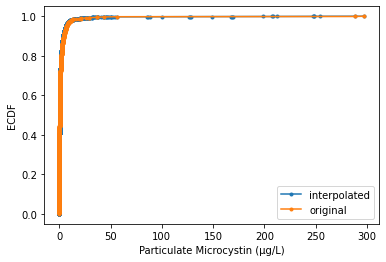

In [12]:
comp_ecdf(interpolated_features, sites_df, 'Particulate Microcystin (µg/L)', 
          name1='interpolated', name2='original')

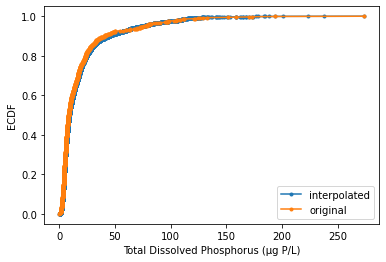

In [13]:
comp_ecdf(interpolated_features, sites_df, 'Total Dissolved Phosphorus (µg P/L)', 
          name1='interpolated', name2='original')

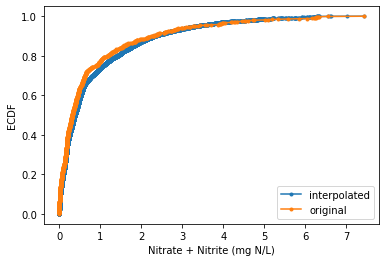

In [14]:
comp_ecdf(interpolated_features, sites_df, 'Nitrate + Nitrite (mg N/L)', 
          name1='interpolated', name2='original')

The interpolated and original distributions are quite similar. Let's examine how the linear interpolation and time-shifted data looks for one site, WE2.

In [15]:
def timeplot(df, cols, datecol='Date', logy=False, squish=False, title=None):
    
    """Plots columns in a dataframe with a DateTime column as subplots with the DateTime as the x-axis. The DateTime
    column is assumed to be named 'Date' or can be entered as an input. Columns should be in list format, and 
    the y-axis can optionally be plotted on a log scale by setting logy=True. If the squish option is set to True
    then the Dates will be processed as strings, removing proper date scaling on the x-axis by removing Dates with 
    null values in all columns."""
    
    #insert dummy NaNs for January months to prevent linear interpolation from year to year
    years = df.Date.dt.year.unique()
    null = pd.DataFrame(data={'Date': [pd.to_datetime('{0}-01-01'.format(y)) for y in years]})
    temp = df.append(null).sort_values(datecol)
    
    if not squish:
        #years = df.Date.dt.year.unique()
        #null = pd.DataFrame(data={'Date': [pd.to_datetime('{0}-01-01'.format(y)) for y in years]})
        #temp = df.append(null).sort_values(datecol)
        temp.plot(x=datecol, y=cols, subplots=True, marker='.', logy=logy, figsize=(15, len(cols)*4), title=title)
        
    if squish:
        temp['DateString'] = temp[datecol].astype('str')
        temp.plot(x='DateString', y=cols, subplots=True, marker='.', logy=logy, figsize=(15, len(cols)*4), title=title)

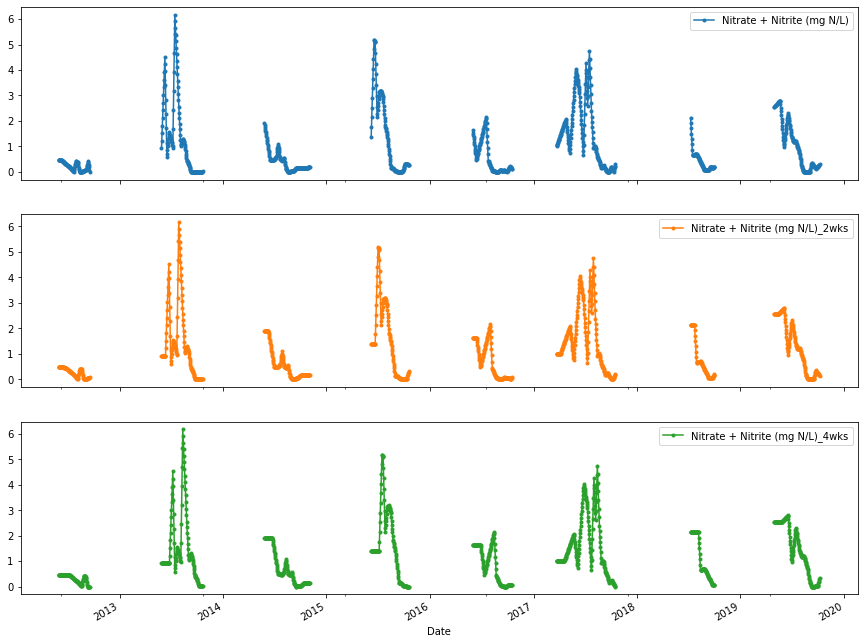

In [16]:
we2 = interpolated_features[interpolated_features.Site == 'WE2']
timeplot(we2.reset_index(), ['Nitrate + Nitrite (mg N/L)','Nitrate + Nitrite (mg N/L)_2wks','Nitrate + Nitrite (mg N/L)_4wks'], logy=False)


The linear interpolation preserves the general features of the data, and we can see the time shift as expected.

## Scaling and Power Transformations

Let's take another look at the feature distributions before scaling. For an in-depth discussion of feature distributions see the data wrangling and EDA notebooks.

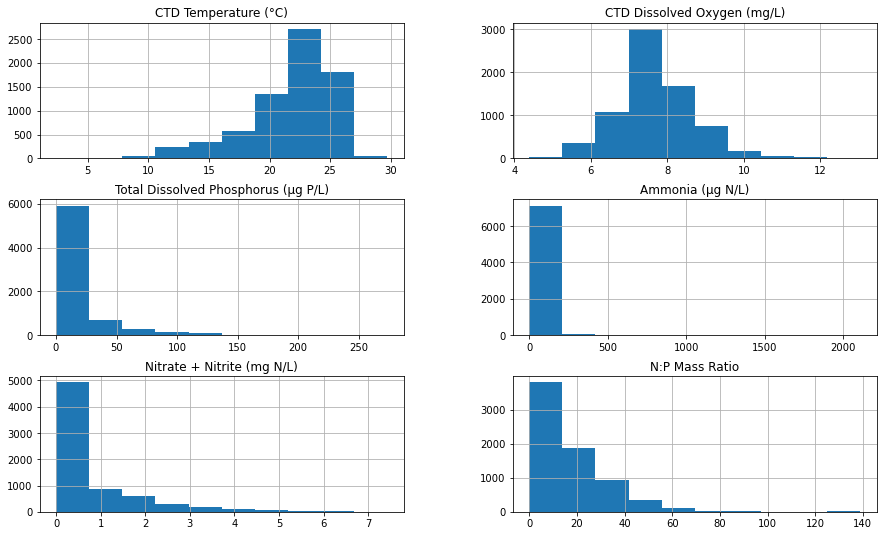

In [17]:
interpolated_features[cols].hist(figsize=(15,9))
plt.show()

The temperature and dissolved oxygen distributions are more similar to already being normally distributed and will be standardized. The chemical features have highly skewed distributions. They will be log transformed to increase the normality of their distributions before they are standardized. Before doing that the data must be split into training and testing sets.

In [18]:
X = interpolated_features.drop(columns='Particulate Microcystin (µg/L)').values
y = interpolated_features['Particulate Microcystin (µg/L)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5738, 35)
(1435, 35)
(5738,)
(1435,)


In [19]:
pd.DataFrame(X_train, columns=interpolated_features.drop(columns='Particulate Microcystin (µg/L)').columns)

,Site,CTD Temperature (°C),CTD Dissolved Oxygen (mg/L),Total Phosphorus (µg P/L),Total Dissolved Phosphorus (µg P/L),Ammonia (µg N/L),Nitrate + Nitrite (mg N/L),N:P Mass Ratio,Distance from Maumee Inlet (km),Shore Distance (euc dis),...,Ammonia (µg N/L)_6wks,Nitrate + Nitrite (mg N/L)_1wk,Nitrate + Nitrite (mg N/L)_2wks,Nitrate + Nitrite (mg N/L)_4wks,Nitrate + Nitrite (mg N/L)_6wks,N:P Mass Ratio_1wk,N:P Mass Ratio_2wks,N:P Mass Ratio_4wks,N:P Mass Ratio_6wks,Month
0,WE16,20.1077,6.19231,38.0008,20.0038,28.8154,0.163231,3.75593,26.892,0.0372167,...,16.7529,0.02325,0.0855714,0.00466667,0.0311429,0.677457,1.67528,0.142299,0.823202,9
1,WE4,21.1,8.11857,32.0843,9.07571,19.5914,0.413714,25.7137,26.7886,0.128644,...,28.63,0.366429,0.637,0.327,0.327,11.7866,32.2695,25.507,25.507,7
2,WE13,21.6143,6.57143,31.2429,4.39714,54.08,0.0681429,5.25441,27.9044,0.12229,...,4.22,0.008,0.0591333,0.187286,0.127286,0.288844,3.51754,13.7454,6.67876,9
3,WE2,25.9,7.00571,47.0829,9.94286,34.6971,1.34314,27.0868,13.4397,0.0550415,...,31.6986,3.05871,4.03633,2.66267,2.22229,34.7189,24.301,33.3175,33.6116,7
4,WE12,24.5667,7.28833,86.1733,29.1233,55.02,2.50667,30.5152,17.7149,0.0359825,...,41.64,0.761667,1.206,1.32057,1.95246,35.6709,31.3036,38.7991,29.9443,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,WE13,23.9,7.55,13.47,1.865,8.255,0.327,24.8692,27.7526,0.120534,...,2.6275,0.3995,0.474786,0.4544,0.3116,26.092,29.8528,26.5979,33.6927,7
5734,WE4,23.1667,7.73333,30.1378,14.3589,46.8156,0.589778,20.6414,26.8684,0.127698,...,13.07,0.546222,0.491143,0.776,0.902,35.1215,52.7899,41.2767,57.8947,7
5735,WE13,23.3167,8.79667,38.825,6.37667,3.15,0.0938333,2.4386,28.1134,0.123112,...,6.18167,0.09325,0.104714,0.351286,0.5865,3.06535,3.10059,16.7532,9.7281,8
5736,WE2,18.5318,6.37727,137.975,77.59,41.5018,3.88614,27.7548,13.1371,0.0534943,...,85.3342,2.83709,1.78805,1.45785,1.81606,22.9545,18.1541,12.93,13.8909,5


In [20]:
y_train.shape

(5738,)

In [21]:
#select skewed features for X and y train and test sets
powerdf_Xtrain = pd.DataFrame(X_train, columns=interpolated_features.drop(columns='Particulate Microcystin (µg/L)').columns).drop(columns=['Site','Month', 'CTD Temperature (°C)','CTD Dissolved Oxygen (mg/L)'])
powerdf_Xtest = pd.DataFrame(X_train, columns=interpolated_features.drop(columns='Particulate Microcystin (µg/L)').columns).drop(columns=['Site','Month', 'CTD Temperature (°C)','CTD Dissolved Oxygen (mg/L)'])

powerdf_ytrain = pd.DataFrame({'Particulate Microcystin (µg/L)': y_train})
powerdf_ytest = pd.DataFrame({'Particulate Microcystin (µg/L)': y_test})


In [22]:
#fit and transform skewed features with power transformer
logX = PowerTransformer()
logX.fit(powerdf_Xtrain)
logfit_Xtrain = logX.transform(powerdf_Xtrain)
logfit_Xtest = logX.transform(powerdf_Xtest)

logY = PowerTransformer()
logY.fit(powerdf_ytrain)
logfit_ytrain = logY.transform(powerdf_ytrain)
logfit_ytest = logY.transform(powerdf_ytest)

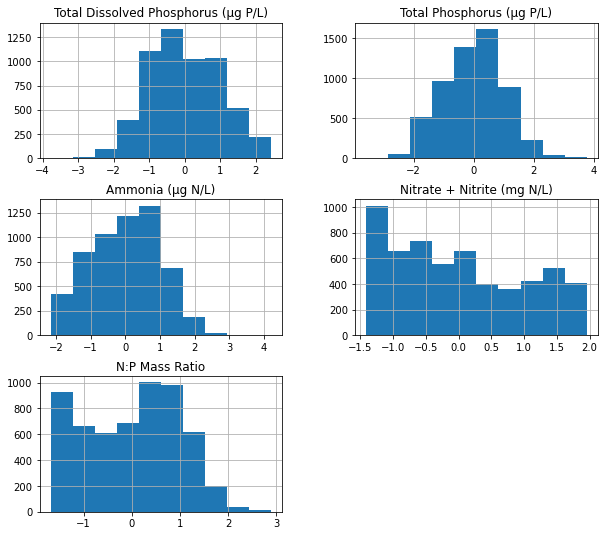

In [23]:
#rename transformed features with appropriate column labels
powerdf_Xtrain = pd.DataFrame(logfit_Xtrain, columns=powerdf_Xtrain.columns)
powerdf_Xtest = pd.DataFrame(logfit_Xtest, columns=powerdf_Xtrain.columns)
scaled_ytrain = pd.DataFrame({'Particulate Microcystin (µg/L)': logfit_ytrain.flatten()})
scaled_ytest = pd.DataFrame({'Particulate Microcystin (µg/L)': logfit_ytest.flatten()})

powerdf_Xtrain[['Total Dissolved Phosphorus (µg P/L)',
         'Total Phosphorus (µg P/L)',
         'Ammonia (µg N/L)', 
         'Nitrate + Nitrite (mg N/L)', 
         'N:P Mass Ratio']].hist(figsize=(10,9))
plt.show()

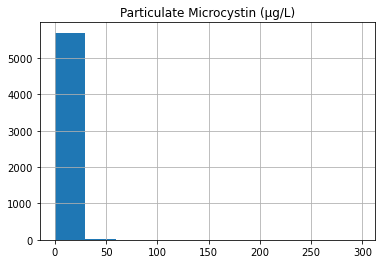

In [24]:
powerdf_ytrain.hist()
plt.show()

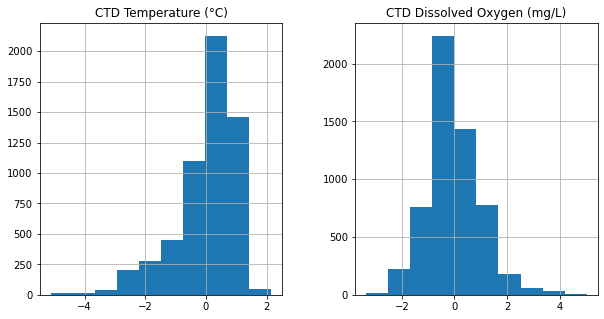

In [25]:
#select and scale temperature and dissolved oxygen features
ctddf_Xtrain = pd.DataFrame(X_train, columns=interpolated_features.drop(columns='Particulate Microcystin (µg/L)').columns)[['CTD Temperature (°C)','CTD Dissolved Oxygen (mg/L)']]
ctddf_Xtest = pd.DataFrame(X_test, columns=interpolated_features.drop(columns='Particulate Microcystin (µg/L)').columns)[['CTD Temperature (°C)','CTD Dissolved Oxygen (mg/L)']]

ss = StandardScaler()
ss.fit(ctddf_Xtrain)
ctddf_Xtrain = pd.DataFrame(ss.transform(ctddf_Xtrain), columns=['CTD Temperature (°C)','CTD Dissolved Oxygen (mg/L)'])
ctddf_Xtest = pd.DataFrame(ss.transform(ctddf_Xtest), columns=['CTD Temperature (°C)','CTD Dissolved Oxygen (mg/L)'])

ctddf_Xtrain.hist(figsize=(10,5))
plt.show()


In [26]:
#recombine scaled features and get dummies for categorical variables - site and month
scaled_Xtrain = pd.concat([pd.get_dummies(pd.DataFrame(X_train, columns=interpolated_features.drop(columns='Particulate Microcystin (µg/L)').columns)[['Site', 'Month']]), 
                    ctddf_Xtrain, powerdf_Xtrain], axis=1)
scaled_Xtest = pd.concat([pd.get_dummies(pd.DataFrame(X_test, columns=interpolated_features.drop(columns='Particulate Microcystin (µg/L)').columns)[['Site', 'Month']]), 
                    ctddf_Xtest, powerdf_Xtest], axis=1)


In [27]:
scaled_Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5738 entries, 0 to 5737
Data columns (total 51 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Site_WE12                                 5738 non-null   uint8  
 1   Site_WE13                                 5738 non-null   uint8  
 2   Site_WE14                                 5738 non-null   uint8  
 3   Site_WE15                                 5738 non-null   uint8  
 4   Site_WE16                                 5738 non-null   uint8  
 5   Site_WE2                                  5738 non-null   uint8  
 6   Site_WE4                                  5738 non-null   uint8  
 7   Site_WE6                                  5738 non-null   uint8  
 8   Site_WE8                                  5738 non-null   uint8  
 9   Month_3                                   5738 non-null   uint8  
 10  Month_4                             

## Principle Component Analysis

Let's explore if linear combinations of our features can capture the variance of the data using fewer dimensions. While we may not intend to use PCA to generate new features used for machine learning this perhaps still give some insight into the data. We will start by just looking at the on-date data (none of the time-shifted data).

In [28]:
#select X features
Xs = scaled_Xtrain.iloc[:,:27].values
Xs.shape

(5738, 27)

In [29]:
#initialize and fit PCA object
pca = PCA()
pca.fit(Xs)

PCA()

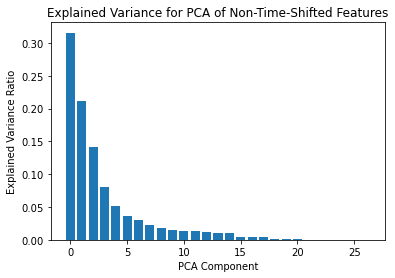

In [30]:
#plot explained variance for each component
plt.bar(list(range(27)), pca.explained_variance_ratio_)
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance for PCA of Non-Time-Shifted Features')
plt.show()

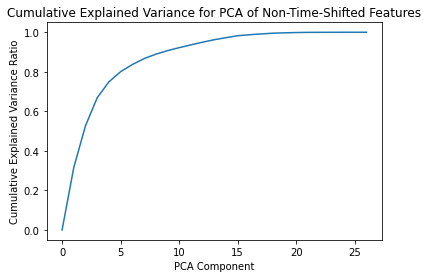

In [31]:
plt.plot(list(range(27)), [sum(pca.explained_variance_ratio_[:i]) for i in range(27)])
plt.xlabel('PCA Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance for PCA of Non-Time-Shifted Features')
plt.show()

The first five components seem to explain about 80% of the variance in the data, and the first three components seem to account for 65% to 70% of the variance in the data.

In [32]:
#select first and second PCA coordinates for each feature point
x0 = pca.fit_transform(Xs)[:,0]
x1 = pca.fit_transform(Xs)[:,1]
x2 = pca.fit_transform(Xs)[:,2]

Let's plot the data with the PCA components as our basis vectors and scaled particulate microcystin level as the hue.

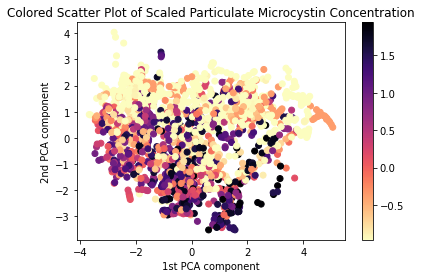

In [33]:
plt.scatter(x0[::3], x1[::3], c=scaled_ytrain['Particulate Microcystin (µg/L)'][::3], cmap='magma_r')
plt.xlabel('1st PCA component')
plt.ylabel('2nd PCA component')
plt.title('Colored Scatter Plot of Scaled Particulate Microcystin Concentration')
plt.colorbar()
plt.show()

There doesn't seem to be much meaningful separation of the microcystin levels with just two pca components, but we can also plot in three dimensions.

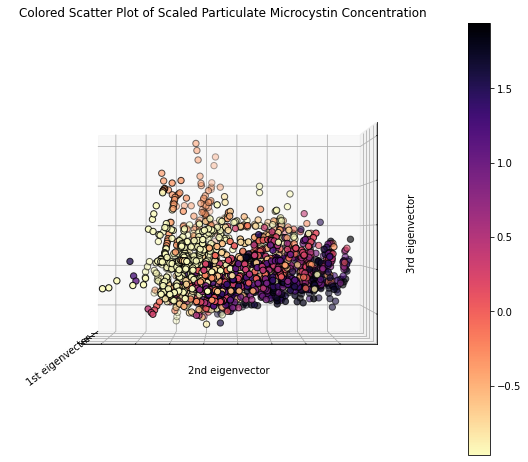

In [34]:
#generate 3D scatterplot of first three PCA components - take every 3rd data point to see plot more clearly.
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=0, azim=180)
p = ax.scatter(x0[::3], x1[::3], x2[::3], c=scaled_ytrain['Particulate Microcystin (µg/L)'][::3],
           cmap='magma_r', edgecolor='k', s=40)
plt.colorbar(p)
ax.set_title("Colored Scatter Plot of Scaled Particulate Microcystin Concentration")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.show()

In the 3D plot we can see some separation and grouping by microcystin level. We can also see linear arrangements of points from the linear interpolation of the data. The second and third eigenvectors seems to be the axes along which the microcystic concentrations are mainly separated.

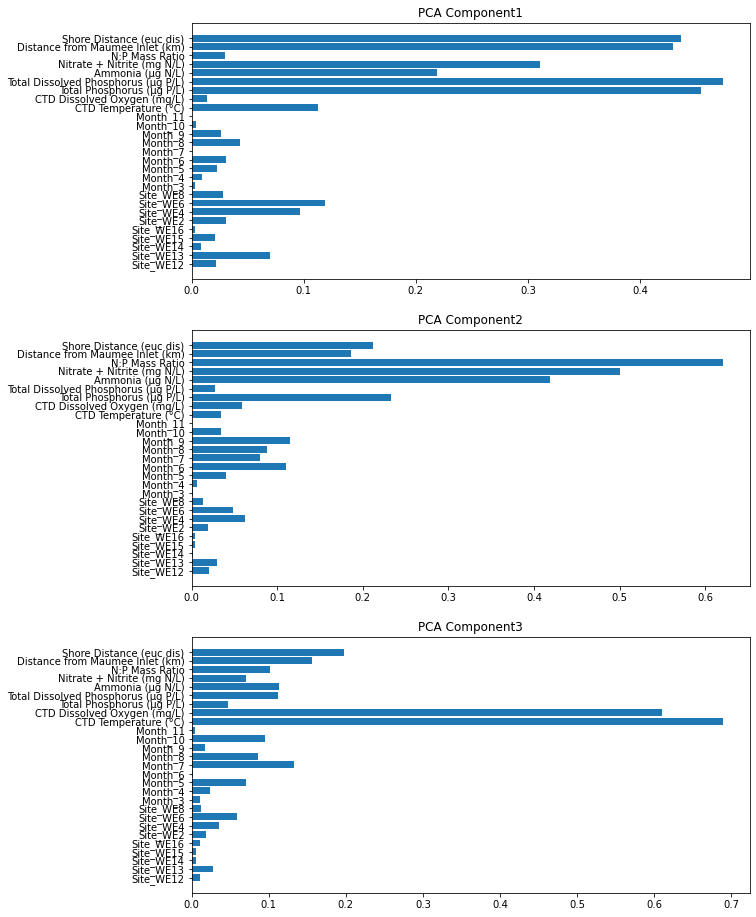

In [35]:
#plot the feature contributions to each pca component
fig, ax = plt.subplots(3, figsize=(10, 16))
for i in range(3):
    ax[i].barh(y=scaled_Xtrain.iloc[:,:27].columns, width=np.abs(pca.components_[i]))
    ax[i].set_title('PCA Component' + str(i+1))
plt.show()

The first PCA component is mainly comprised of location and nutrient features, especially phosphorus. The second PCA component is more heavily composed nitrogen-containing nutrients, N:P mass ratio, and month. The third PCA component is comprised mainly of dissolved oxygen and temperature information. The second and third PCA components seem to be the most effective at separating the data by microcystin concentration.

In [36]:
X_past = scaled_Xtrain.iloc[:,27:51].values
X_past.shape

(5738, 24)

In [37]:
pca_past = PCA()
pca_past.fit(X_past)

PCA()

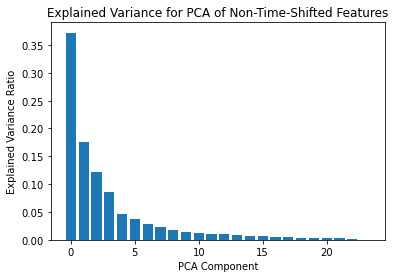

In [38]:
#plot explained variance for each component
plt.bar(list(range(24)), pca_past.explained_variance_ratio_)
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance for PCA of Non-Time-Shifted Features')
plt.show()

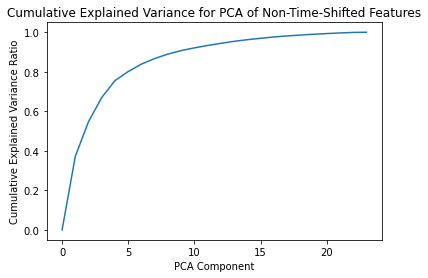

In [39]:
plt.plot(list(range(24)), [sum(pca_past.explained_variance_ratio_[:i]) for i in range(24)])
plt.xlabel('PCA Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance for PCA of Non-Time-Shifted Features')
plt.show()

In [40]:
#select first and second PCA coordinates for each feature point
X_past_transform = pca_past.transform(X_past)
x0_past = X_past_transform[:,0]
x1_past = X_past_transform[:,1]
x2_past = X_past_transform[:,2]

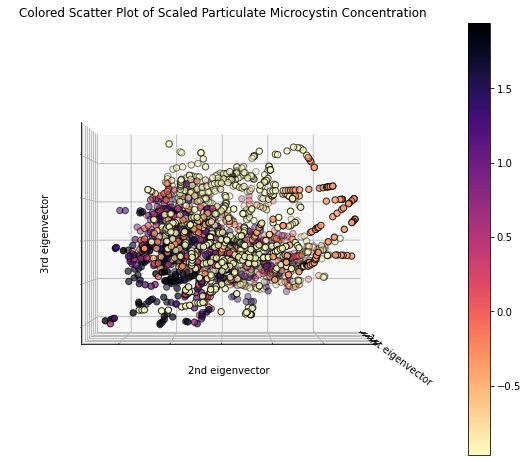

In [41]:
#generate 3D scatterplot of first three PCA components - take every 3rd data point to see plot more clearly.
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=0, azim=0)
p = ax.scatter(x0_past[::3], x1_past[::3], x2_past[::3], c=scaled_ytrain['Particulate Microcystin (µg/L)'][::3],
           cmap='magma_r', edgecolor='k', s=40)
plt.colorbar(p)
ax.set_title("Colored Scatter Plot of Scaled Particulate Microcystin Concentration")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.show()

There is less obvious separation here, although it is interesting that there is some separation even though there is no way to take time of year into account explicitly. The second and third eigenvectors again seem to be the most influential in separating the data by microcystin concentration.

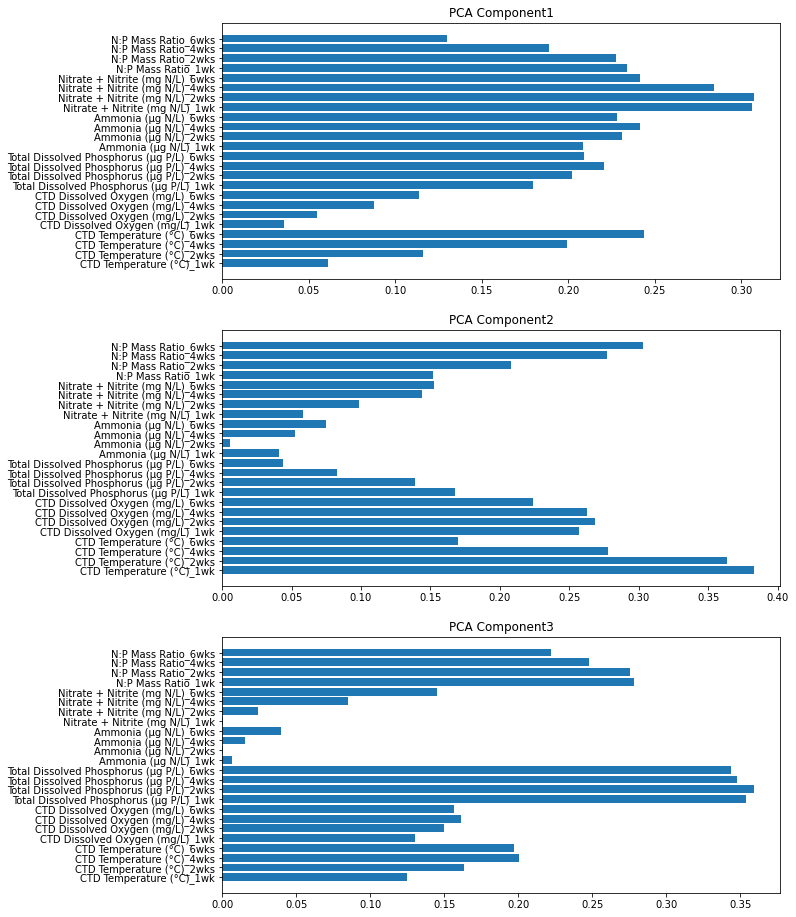

In [42]:
#plot the feature contributions to each pca component
fig, ax = plt.subplots(3, figsize=(10, 16))
for i in range(3):
    ax[i].barh(y=scaled_Xtrain.iloc[:,27:51].columns, width=np.abs(pca_past.components_[i]))
    ax[i].set_title('PCA Component' + str(i+1))
plt.show()

These components are comprised of much more even combinations of the original features. This is perhaps to be expected since a significant number of the features are just time shifts of other features, so they have similar or identical variances.

Let's investigate whether eignevectors composed of certain time shifts do a better job of separating the data by microcystin concentration than others.

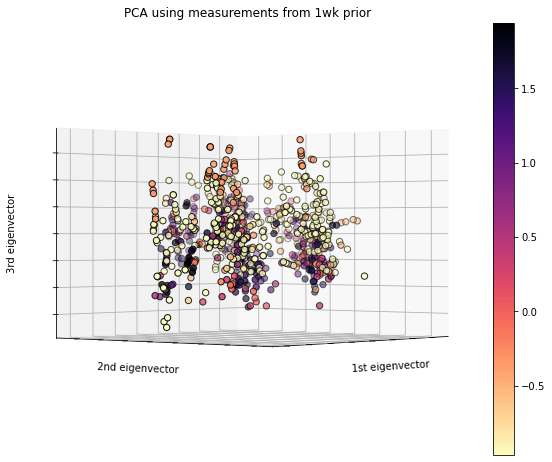

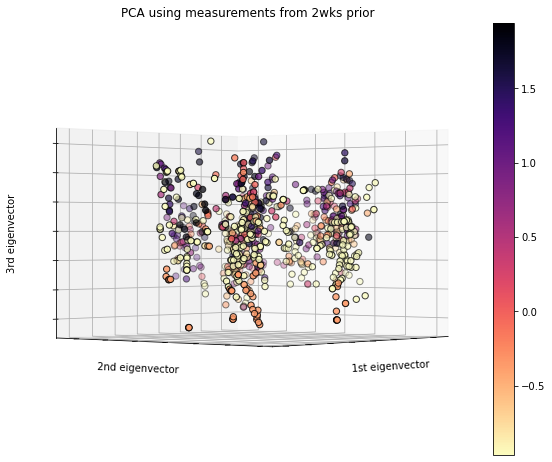

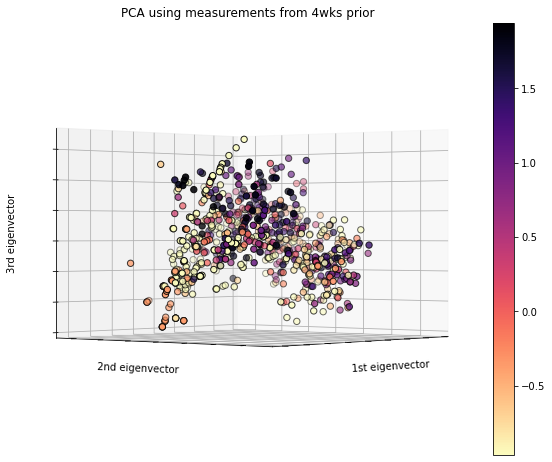

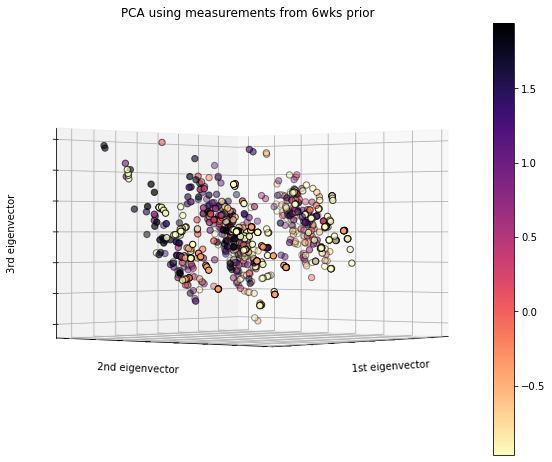

In [43]:
df = scaled_Xtrain.iloc[:,27:50]

for i, shift in enumerate(['1wk', '2wks', '4wks', '6wks']):
    
    #select data that is only from the appropriate number of weeks prior
    final = df.iloc[:,i:24:4].copy()
    final['Shore Distance (euc dis)'] = scaled_Xtrain['Shore Distance (euc dis)'].copy()
    final['Distance from Maumee Inlet (km)'] = scaled_Xtrain['Distance from Maumee Inlet (km)'].copy()
    
    #fit pca object to data
    X_shift = final.values
    pca_shift = PCA(n_components=3)
    pca_shift.fit(X_shift)
    X_trans = pca_shift.transform(X_shift)
    
    #generate 3D scatterplot of first three PCA components - take every 3rd data point to see plot more clearly.
    fig = plt.figure(1, figsize=(8, 6))
    ax = Axes3D(fig, elev=0, azim=40)
    p = ax.scatter(X_trans[::7,0], X_trans[::7,1], X_trans[::7,2], c=scaled_ytrain['Particulate Microcystin (µg/L)'][::7],
           cmap='magma_r', edgecolor='k', s=40)
    plt.colorbar(p)
    ax.set_title("PCA using measurements from " + shift + " prior")
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])
    plt.show()

It is difficult to tell from these plots if there is a significant difference in the separation of the data by microcystin concentration.

## Save Train and Testing Sets

In [44]:
scaled_Xtrain.to_csv('../data/processed/scaled_Xtrain.csv')
scaled_Xtest.to_csv('../data/processed/scaled_Xtest.csv')
scaled_ytrain.to_csv('../data/processed/scaled_ytrain.csv')
scaled_ytest.to_csv('../data/processed/scaled_ytest.csv')